# Lista 05 - IC + Teste de Hipóteses

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.stats import binom

# Exercício 1

Utilize o dataset dados-covid-mg para explorar a seguinte hipótese:

Hipótese: Em MG cerca de 50% da população já foi detectada com COVID.

Dataset obtido no openDataSUS, um recorte do estado de MG. Para facilitar, algumas colunas foram removidas e o atributo classificacaoFinal foi binarizado.

In [2]:
df = pd.read_csv('dados-covid-mg.csv')
df.head()

,id,profissionalSaude,tipoTeste,resultadoTeste,estado,municipio,classificacaoFinal
0,R3y2Di9K0s,Não,RT-PCR,Negativo,MINAS GERAIS,Varginha,0
1,4awz0HPaCl,Sim,RT-PCR,Negativo,MINAS GERAIS,Carmópolis de Minas,0
2,0RjrlH0bs5,Não,NaN,NaN,MINAS GERAIS,Conselheiro Lafaiete,0
3,83B4gJDLpU,Não,NaN,NaN,MINAS GERAIS,Mariana,0
4,H8GKXacI4T,Não,NaN,NaN,MINAS GERAIS,Januária,0


A) Calcule a prevalência de infectados na amostra, armazene na variável p.

In [3]:
# YOUR CODE HERE
n1 = len(df[df['classificacaoFinal'] == 1]) # número de 'positivos'
n = len(df) # número total de testes

p = n1 / n
p

0.409622523888832

B) Calcule a variância (utilizando p), armazene em var.

In [4]:
# YOUR CODE HERE
var = n1 * p * (1 - p) #variancia de uma binomial
var

21293.299835026814

C) Calcule o intervalo de confiança dessa estimativa, considerando 95% de chance. O resultado deve ser uma tupla a,b armazenada em ic.

In [5]:
# YOUR CODE HERE
inferior = p - (1.96 * math.sqrt(p * (1 - p) / n))
superior = p + (1.96 * math.sqrt(p * (1 - p) / n))
ic = [inferior, superior]

D) Quais as afirmações analíticas podem ser feitas com base nessa exploração? Se julgar necessário plote gráficos que corroborem a análise.

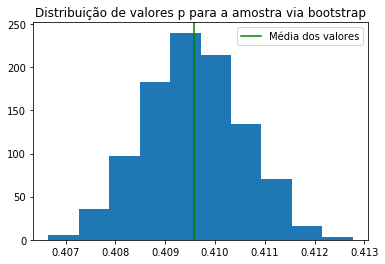

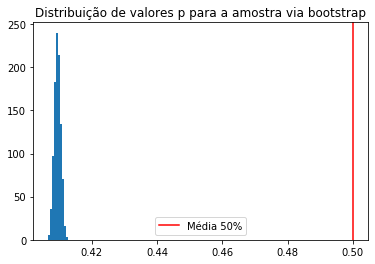

In [6]:
# YOUR CODE HERE

# Vamos utilizar, além do IC, a técnica de Bootstrap para tentar dizer se a média da amostra
# se aproxima da média da população

def bootstrap_p(pop, n, size):
    pop_size = len(pop) # número total de testes
    values = np.zeros(n)
    
    for i in range(n):
        sample = pop.sample(size, replace=True)
        n1 = len(sample[sample['classificacaoFinal'] == 1]) # número de 'positivos'
        p = n1 / pop_size
        values[i] = p
    return values

# O método confirma que o valor real de p se aproxima de algum número no intervalo [0.407, 0.411]
# como visto acima. O seguinte gráfico mostra essa informação:

b = bootstrap_p(df, 1000, len(df))
plt.axvline(x=b.mean(), color='green', label="Média dos valores")
plt.hist(b)
plt.title("Distribuição de valores p para a amostra via bootstrap")
plt.legend()
plt.show()

# O seguinte gráfico mostra o quão distante o valor que indica que "50% da população já foi infectada com COVID"
# se encontra dos dados simulados pelo método bootstrap. Percebemos, então, que essa afirmação
# provavelmente está incorreta.

plt.axvline(x=0.5, color='red', label="Média 50%")
plt.hist(b)
plt.title("Distribuição de valores p para a amostra via bootstrap")
plt.legend()
plt.show()

# Exercício 2

Hipótese Nula: A prevalência de COVID para profissionais de saúde é igual a de não profissionais de saúde.

Utilize o teste de permutação para randomizando os dados, aproximar o p-valor e validar se a hipótese é aceita.

In [7]:
#Convertendo as series para numpy
profissionais = df['profissionalSaude'].to_numpy()
classificacaoFinal = df['classificacaoFinal'].to_numpy()

A) Calcule t_obs, armazene em t_obs.

In [8]:
# YOUR CODE HERE

def observed_statistic(profissionais, classificacao):
    isProfissional = profissionais == 'Sim'
    isContaminado = classificacao == 1

    # Calcula p para profissionais infectados
    qtd_profissionais_infectados = len(classificacao[isProfissional & isContaminado])
    qtd_profissionais_total = len(profissionais[isProfissional])
    p_profissionais_infectados = qtd_profissionais_infectados / qtd_profissionais_total

    # Calcula p para não profissionais infectados
    qtd_nao_profissionais_infectados = len(classificacao[~isProfissional & isContaminado])
    qtd_nao_profissionais_total = len(profissionais[~isProfissional])
    p_nao_profissionais_infectados = qtd_nao_profissionais_infectados / qtd_nao_profissionais_total

    t_obs = p_profissionais_infectados - p_nao_profissionais_infectados
    return t_obs

t_obs = observed_statistic(profissionais, classificacaoFinal)

B) Implemente o teste de permutação para os dados

Relembrando: Shuffle, computar diferença média, fazer isso n vezes.

Para sua análise utilize o valor de N que considerar adequado, no entanto na entrega fixe N em 1000. Armazene a lista de diferenças em diferencas.

In [9]:
# YOUR CODE HERE
def teste_permutacao(p):
    diferencas = np.zeros(1000)
    for i in range(1000):
        np.random.shuffle(p)
        diferencas[i] = observed_statistic(p, classificacaoFinal)
    return diferencas

C) Plote o histograma e avalie qual a chance de um t_obs maior que os dados.

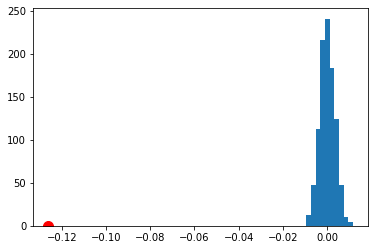

In [10]:
# YOUR CODE HERE
diferencas = teste_permutacao(profissionais)
plt.hist(diferencas)
plt.plot(t_obs, 0, 'ro', ms=10)

D) A hipótese nula é aceita ou rejeitada? Explique

A hipótese nula é rejeitada. O valor reportado tem probabilidade nula de acontecer no caso de a prevalência de COVID para profissionais de saúde ser igual a de não profissionais de saúde.